# Tree Crown Detection and Individual Tree Quantification with Detectron2 and DeepForest

In [ ]:
!pip install torch torchvision --quiet
!pip install rasterio tqdm pyproj matplotlib deepforest --quiet
!pip install pyyaml==5.1 --quiet
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install git+https://github.com/PatBall1/detectree2.git

In [1]:
# !pip uninstall -y numpy

# !pip install "numpy>=1.24.0,<2.0.0"

# !pip install --upgrade numba

In [ ]:
import os
import json
import glob
import random
from pathlib import Path
import cv2
import torch
from tqdm import tqdm
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from deepforest import main

from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.cv import visualize_object_predictions


import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
# specify paths to your images location

photo1_path = ""
photo2_path = ''

tiles1_path = 'dataset1/tiles'
tiles2_path = 'dataset2/tiles'

output1_path = ""
output2_path = ""

In [3]:
with rasterio.open(photo1_path) as src:
    print("--- Image Metadata ---")
    print(f"Number of bands (count): {src.count}")
    print(f"Nodata value definition: {src.nodata}")
    print(f"Data type (dtype): {src.dtypes[0]}")
    print(f"Mask flags: {src.mask_flag_enums}")

--- Image Metadata ---
Number of bands (count): 4
Nodata value definition: None
Data type (dtype): uint8
Mask flags: ([<MaskFlags.per_dataset: 2>, <MaskFlags.alpha: 4>], [<MaskFlags.per_dataset: 2>, <MaskFlags.alpha: 4>], [<MaskFlags.per_dataset: 2>, <MaskFlags.alpha: 4>], [<MaskFlags.all_valid: 1>])


In [4]:
def is_tile_useful(tile_data, threshold_pct=0.01):
    """
    Returns True if the tile has more valid data (non-zero alpha) than the threshold_pct (0.0 to 1.0).
    """
    alpha_channel = tile_data[3, :, :]

    valid_pixels = np.count_nonzero(alpha_channel)

    total_pixels = alpha_channel.size

    valid_data_pct = valid_pixels / total_pixels

    return valid_data_pct >= threshold_pct

In [5]:
def chip_image(tif_path, output_dir, tile_size=1024, overlap=0):
    os.makedirs(output_dir, exist_ok=True)

    with rasterio.open(tif_path) as src:
        width = src.width
        height = src.height

        print(f"Processing {tif_path} ({width}x{height})...")

        count_saved = 0
        count_skipped = 0

        for y in range(0, height, tile_size - overlap):
            for x in range(0, width, tile_size - overlap):


                w = min(tile_size, width - x)
                h = min(tile_size, height - y)
                window = Window(x, y, w, h)

                tile_data = src.read(window=window)

                if not is_tile_useful(tile_data, threshold_pct=0.05):
                    count_skipped += 1
                    continue

                img_hwc = tile_data.transpose(1, 2, 0)

                img_bgr = cv2.cvtColor(img_hwc[:, :, :3], cv2.COLOR_RGB2BGR)

                filename = f"tile_{x}_{y}.png"
                out_path = os.path.join(output_dir, filename)
                cv2.imwrite(out_path, img_bgr)

                count_saved += 1

        print(f"Done! Saved: {count_saved} tiles. Skipped: {count_skipped} tiles.")

In [6]:
chip_image(photo1_path, tiles1_path)

chip_image(photo2_path, tiles2_path)

Processing /content/drive/MyDrive/orthophotos/tarurtyn_balka_fragm01.tif (22951x19549)...
Done! Saved: 240 tiles. Skipped: 220 tiles.
Processing /content/drive/MyDrive/orthophotos/tarutyn_voiler_rendered_fragm01.tif (24378x16188)...
Done! Saved: 296 tiles. Skipped: 88 tiles.


Found 240 valid tiles.


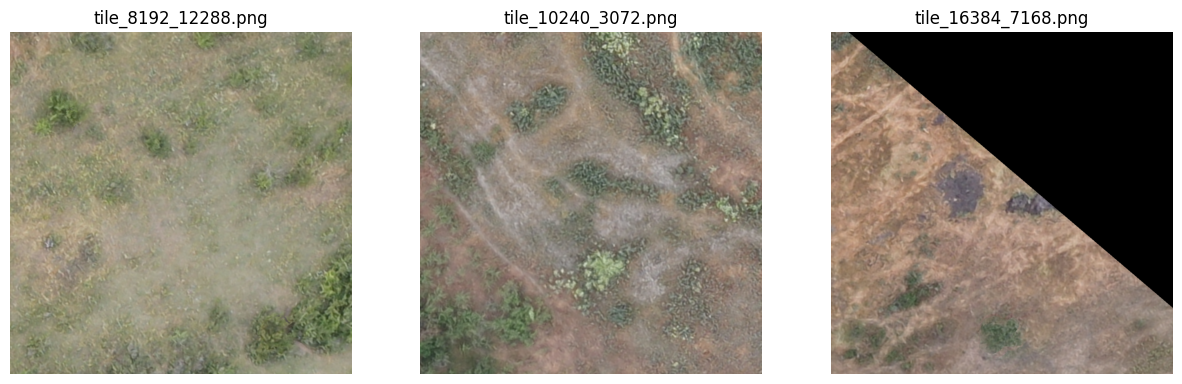

In [7]:
random.seed(42)

tile_files = glob.glob(os.path.join(tiles1_path, "*.png"))
print(f"Found {len(tile_files)} valid tiles.")

samples = random.sample(tile_files, min(3, len(tile_files)))

plt.figure(figsize=(15, 5))
for i, file_path in enumerate(samples):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(file_path))
    plt.axis('off')
plt.show()

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

weights_url = "https://zenodo.org/record/15014353/files/230103_randresize_full.pth?download=1"
weights_file = "forest_model.pth"

if not os.path.exists(weights_file):
    print("Downloading Model Weights...")
    !wget -O {weights_file} "{weights_url}"

cfg.MODEL.WEIGHTS = weights_file
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# sensitivity: lower = more trees (more creative), higher = fewer errors (more robust)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)
tile_dir = tiles1_path
png_files = glob.glob(os.path.join(tile_dir, "*.png"))

total_trees = 0
results = []

print(f"Starting inference on {len(png_files)} tiles")

for img_path in tqdm(png_files):
    im = cv2.imread(img_path)

    outputs = predictor(im)

    count = len(outputs["instances"])
    total_trees += count

    if count > 0:
        results.append((img_path, outputs["instances"].to("cpu")))

print(f"\nTOTAL TREES DETECTED: {total_trees}")

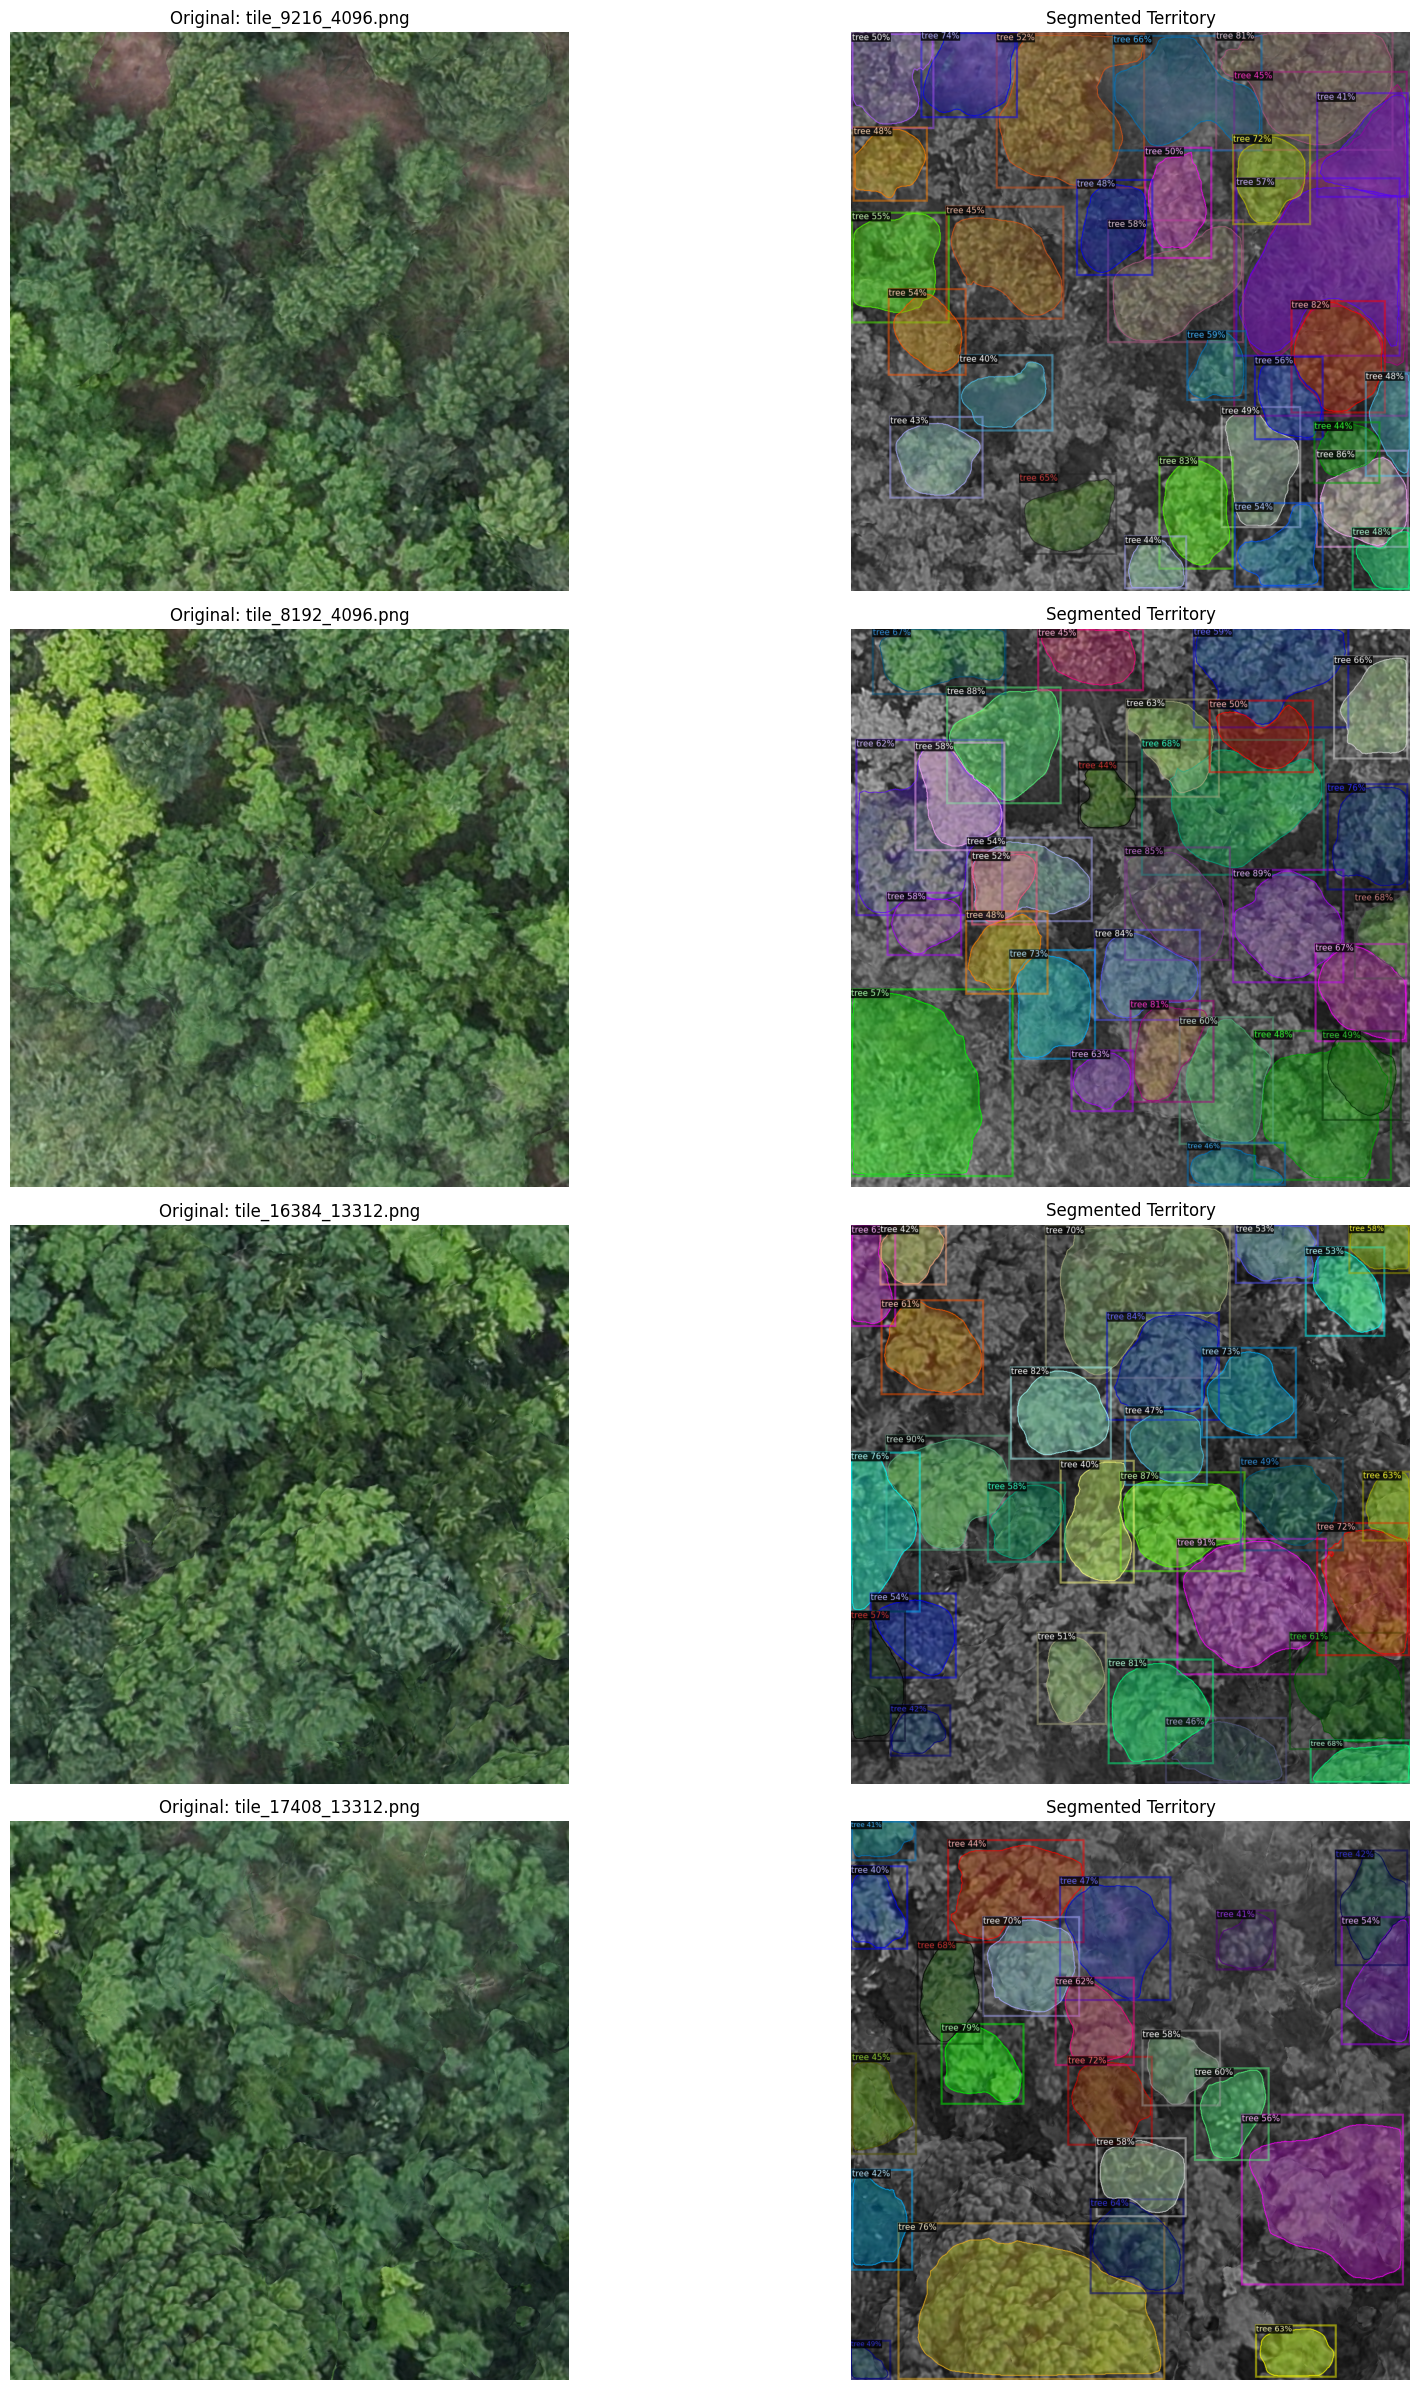

In [9]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import os

try:
    tree_metadata = MetadataCatalog.get("tree_detector")
except KeyError:
    MetadataCatalog.register("tree_detector", lambda: {})
    tree_metadata = MetadataCatalog.get("tree_detector")
tree_metadata.thing_classes = ["tree"]

sorted_results = sorted(results, key=lambda x: len(x[1]), reverse=True)

num_to_show = min(4, len(sorted_results))

if num_to_show == 0:
    print("No trees detected to visualize.")
else:
    plt.figure(figsize=(20, num_to_show * 6))

    for i in range(num_to_show):
        img_path, instances = sorted_results[i]

        im_bgr = cv2.imread(img_path)
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)


        v = Visualizer(im_rgb, metadata=tree_metadata, scale=1.0, instance_mode=ColorMode.IMAGE_BW)
        out = v.draw_instance_predictions(instances)
        viz_img = out.get_image()


        plt.subplot(num_to_show, 2, i*2 + 1)
        plt.imshow(im_rgb)
        plt.title(f"Original: {os.path.basename(img_path)}")
        plt.axis("off")

        plt.subplot(num_to_show, 2, i*2 + 2)
        plt.imshow(viz_img)
        density = len(instances)
        plt.title(f"Segmented Territory")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### DeepForest approach

In [3]:
Image.MAX_IMAGE_PIXELS = None

In [ ]:
df_model = main.deepforest()
df_model.use_gpu = True
df_model.load_model(model_name='weecology/deepforest-tree')

In [5]:
with rasterio.open(photo2_path) as src:
    rgb = src.read([1, 2, 3])

    profile = src.profile
    profile.update(count=3)

    with rasterio.open(output2_path, "w", **profile) as dst:
        dst.write(rgb)

In [ ]:
predictions = df_model.predict_tile(
    path=output2_path,
    patch_size=800,
    patch_overlap=0.1,
    iou_threshold=0.4 # confidence threshold (higher -> more robust)
)

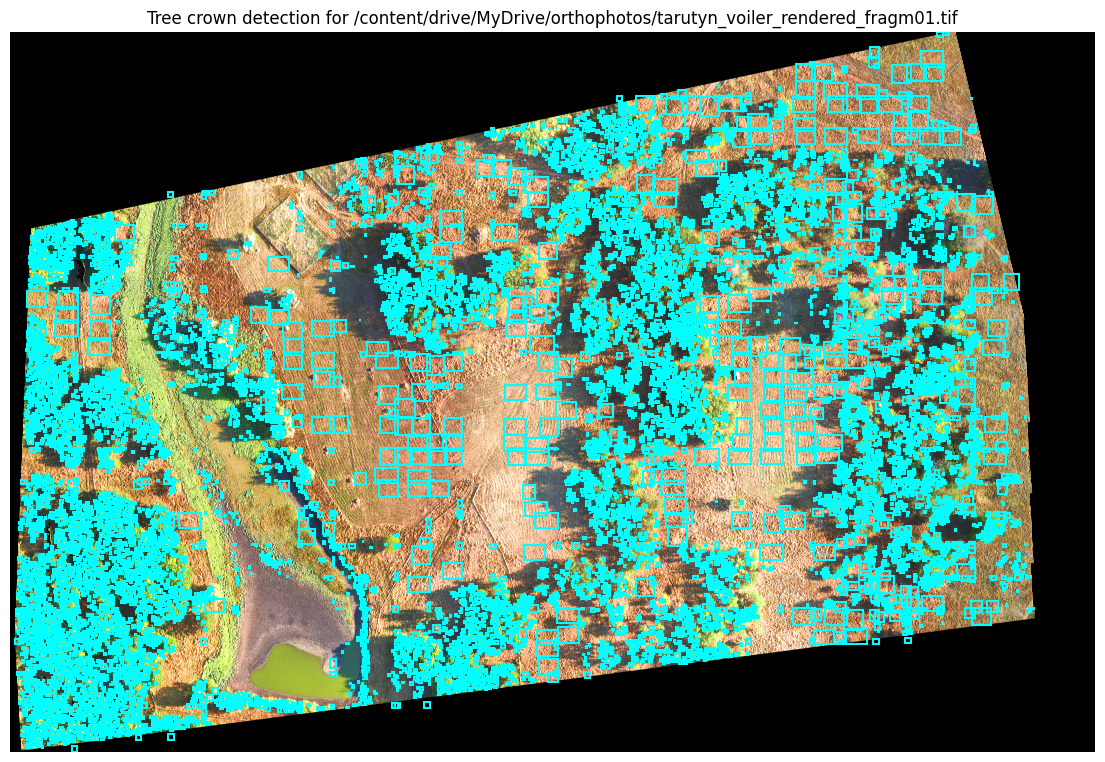

In [7]:
with rasterio.open(photo2_path) as src:
    img = src.read([1, 2, 3])
    img = img.transpose((1, 2, 0))

plt.figure(figsize=(14, 14))
plt.imshow(img)

ax = plt.gca()
for _, row in predictions.iterrows():
    x1, y1 = row["xmin"], row["ymin"]
    w = row["xmax"] - row["xmin"]
    h = row["ymax"] - row["ymin"]
    ax.add_patch(patches.Rectangle(
        (x1, y1), w, h,
        fill=False, edgecolor='cyan', linewidth=1.5
    ))

plt.title(f"Tree crown detection for {photo2_path}")
plt.axis("off")
plt.show()

In [ ]:
with rasterio.open(photo1_path) as src:
    rgb = src.read([1, 2, 3])

    profile = src.profile
    profile.update(count=3)

    with rasterio.open(output1_path, "w", **profile) as dst:
        dst.write(rgb)

predictions1 = df_model.predict_tile(
    path=output1_path,
    patch_size=700,
    patch_overlap=0.1,
    iou_threshold=0.4
)

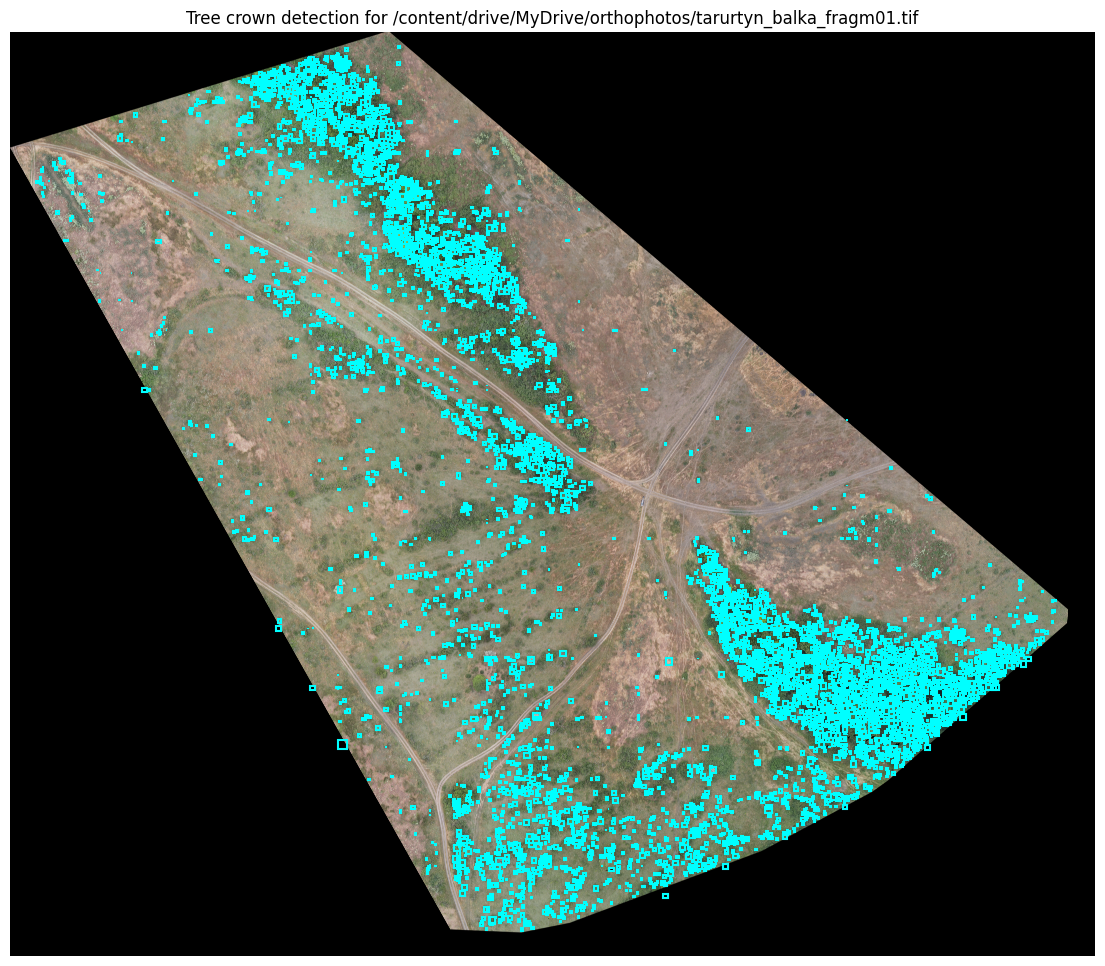

In [10]:
with rasterio.open(photo1_path) as src:
    img = src.read([1, 2, 3])
    img = img.transpose((1, 2, 0))

plt.figure(figsize=(14, 14))
plt.imshow(img)

ax = plt.gca()
for _, row in predictions1.iterrows():
    x1, y1 = row["xmin"], row["ymin"]
    w = row["xmax"] - row["xmin"]
    h = row["ymax"] - row["ymin"]
    ax.add_patch(patches.Rectangle(
        (x1, y1), w, h,
        fill=False, edgecolor='cyan', linewidth=1.5
    ))

plt.title(f"Tree crown detection for {photo1_path}")
plt.axis("off")
plt.show()